# Prediciendo la diabetes
## El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.

# 1.0 Importamos las librerias a utilizar

In [1]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import joblib
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

 # 1.1 Importamos los datos

In [3]:
df = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/diabetes.csv')
pd.set_option('display.max_columns', None)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

# 2.1 Identificamos columnas con valores unicos

In [5]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
0
1
2
3
4
...
763
764
765
766


# 2.2 Eliminamos filas y columnas duplicadas

In [6]:
# Comporbar ducpliados
df.duplicated().sum()

np.int64(0)

In [7]:
df.T.duplicated().sum()

np.int64(0)

# 2.3 Identificamos columnas redundantes

Tras realizar un análisis superficial del dataset, no se identificaron columnas redundantes evidentes. Cada una de las 9 columnas representa una medida diagnóstica diferente y cumple un propósito específico en la predicción de diabetes.

# 2.4 Eliminar columnas Data leakage

En este dataset no se identificaron columnas que generen data leakage. Todas las variables predictoras representan medidas diagnósticas que se pueden obtener antes de conocer el resultado del diagnóstico de diabetes.

# 2.5 Buscamos valores faltantes

In [8]:
df.shape

(768, 9)

In [9]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

Series([], dtype: float64)

# 2.5.1 Busqueda profunda de valores faltantes

In [10]:
# Buscar valores 0 en columnas específicas
columnas_a_revisar = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']

print("Análisis de valores 0 en columnas clave:")
print("="*60)

for columna in columnas_a_revisar:
    count_zeros = (df[columna] == 0).sum()
    porcentaje = (count_zeros / len(df)) * 100
    print(f"{columna:20s}: {count_zeros:4d} filas con 0 ({porcentaje:.2f}%)")

print("="*60)
print(f"Total de filas en el dataset: {len(df)}")

# Reemplazar valores 0 por NaN para su posterior tratamiento
print("\n" + "="*60)
print("Reemplazando valores 0 por NaN en columnas relevantes...")
print("="*60)

for columna in columnas_a_revisar:
    df[columna] = df[columna].replace(0, np.nan)
    
print("✅ Valores 0 reemplazados por NaN exitosamente")
print(f"\nNuevos valores faltantes por columna:")
faltantes_nuevos = df[columnas_a_revisar].isna().sum()
for columna, cantidad in faltantes_nuevos.items():
    porcentaje = (cantidad / len(df)) * 100
    print(f"{columna:20s}: {cantidad:4d} NaN ({porcentaje:.2f}%)")

Análisis de valores 0 en columnas clave:
Glucose             :    5 filas con 0 (0.65%)
BloodPressure       :   35 filas con 0 (4.56%)
SkinThickness       :  227 filas con 0 (29.56%)
Insulin             :  374 filas con 0 (48.70%)
BMI                 :   11 filas con 0 (1.43%)
Age                 :    0 filas con 0 (0.00%)
Total de filas en el dataset: 768

Reemplazando valores 0 por NaN en columnas relevantes...
✅ Valores 0 reemplazados por NaN exitosamente

Nuevos valores faltantes por columna:
Glucose             :    5 NaN (0.65%)
BloodPressure       :   35 NaN (4.56%)
SkinThickness       :  227 NaN (29.56%)
Insulin             :  374 NaN (48.70%)
BMI                 :   11 NaN (1.43%)
Age                 :    0 NaN (0.00%)


<Axes: >

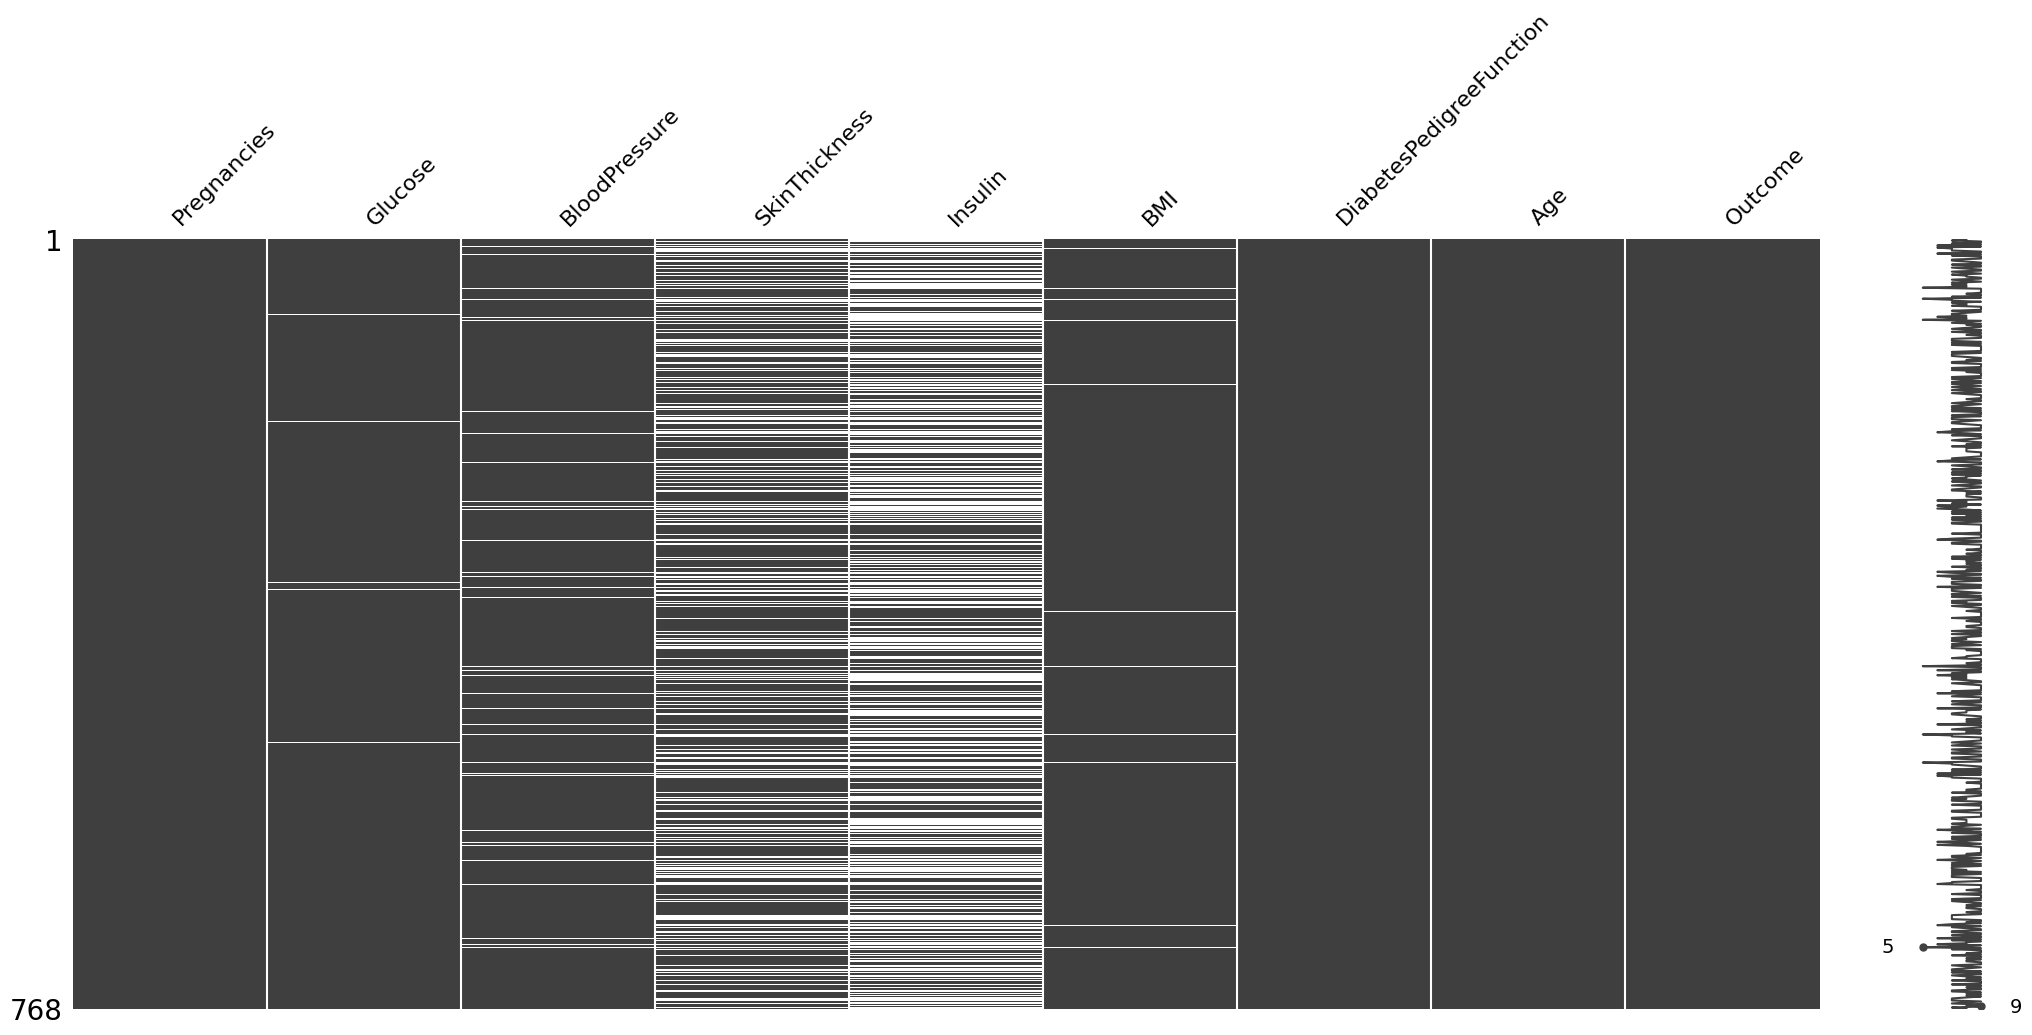

In [11]:
msno.matrix(df)

In [12]:
df.shape

(768, 9)

# 2.6 Tratamiento de valores faltantes

**Decisión:** En lugar de eliminar columnas importantes como Insulin y SkinThickness, utilizaremos **IterativeImputer** que:
- Usa modelos de regresión para predecir valores faltantes
- Aprovecha las correlaciones entre variables
- Mantiene toda la información predictora disponible

Esto es crucial porque variables como Insulin y SkinThickness son importantes para predecir diabetes, a pesar de tener valores faltantes.

In [13]:
# Crear el imputador iterativo
# Este método usa BayesianRidge por defecto para estimar valores faltantes
imputer = IterativeImputer(random_state=42, max_iter=10, verbose=0)

# Obtener todas las columnas predictoras (todas excepto 'Outcome')
columnas_a_imputar = [col for col in df.columns if col != 'Outcome']

print("Columnas a imputar:", columnas_a_imputar)
print("\nAntes de la imputación:")
print(df[columnas_a_imputar].isna().sum())
print(f"\nTotal de valores faltantes: {df[columnas_a_imputar].isna().sum().sum()}")

# Aplicar la imputación solo a las columnas predictoras (sin Outcome)
df_imputado = df.copy()
df_imputado[columnas_a_imputar] = imputer.fit_transform(df[columnas_a_imputar])

print("\n" + "="*60)
print("Después de la imputación:")
print(df_imputado[columnas_a_imputar].isna().sum())
print(f"\nTotal de valores faltantes: {df_imputado[columnas_a_imputar].isna().sum().sum()}")

# Actualizar el dataframe
df = df_imputado.copy()

print("\n✅ Imputación completada exitosamente")
print(f"📊 Forma del dataframe: {df.shape}")

Columnas a imputar: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Antes de la imputación:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

Total de valores faltantes: 652

Después de la imputación:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Total de valores faltantes: 0

✅ Imputación completada exitosamente
📊 Forma del dataframe: (768, 9)


In [14]:
# Verificar que no hay valores negativos después de la imputación
print("Verificación de valores negativos después de la imputación:")
for col in columnas_a_imputar:
    negativos = (df[col] < 0).sum()
    if negativos > 0:
        print(f"⚠️  {col}: {negativos} valores negativos")
        # Corregir valores negativos si existen (reemplazar por la mediana)
        df.loc[df[col] < 0, col] = df[df[col] >= 0][col].median()
    else:
        print(f"✅ {col}: Sin valores negativos")

print("\n" + "="*60)
print("Estadísticas descriptivas después de la imputación:")
print(df[columnas_a_imputar].describe())

Verificación de valores negativos después de la imputación:
✅ Pregnancies: Sin valores negativos
✅ Glucose: Sin valores negativos
✅ BloodPressure: Sin valores negativos
✅ SkinThickness: Sin valores negativos
⚠️  Insulin: 1 valores negativos
✅ BMI: Sin valores negativos
✅ DiabetesPedigreeFunction: Sin valores negativos
✅ Age: Sin valores negativos

Estadísticas descriptivas después de la imputación:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.641941      72.352451      28.906892  152.845252   
std       3.369578   30.466540      12.147216       9.521956   97.146640   
min       0.000000   44.000000      24.000000       7.000000   13.815353   
25%       1.000000   99.000000      64.000000      22.120844   89.996530   
50%       3.000000  117.000000      72.000000      28.447099  130.194786   
75%       6.000000  140.250000      80.000000      35.000000  190.

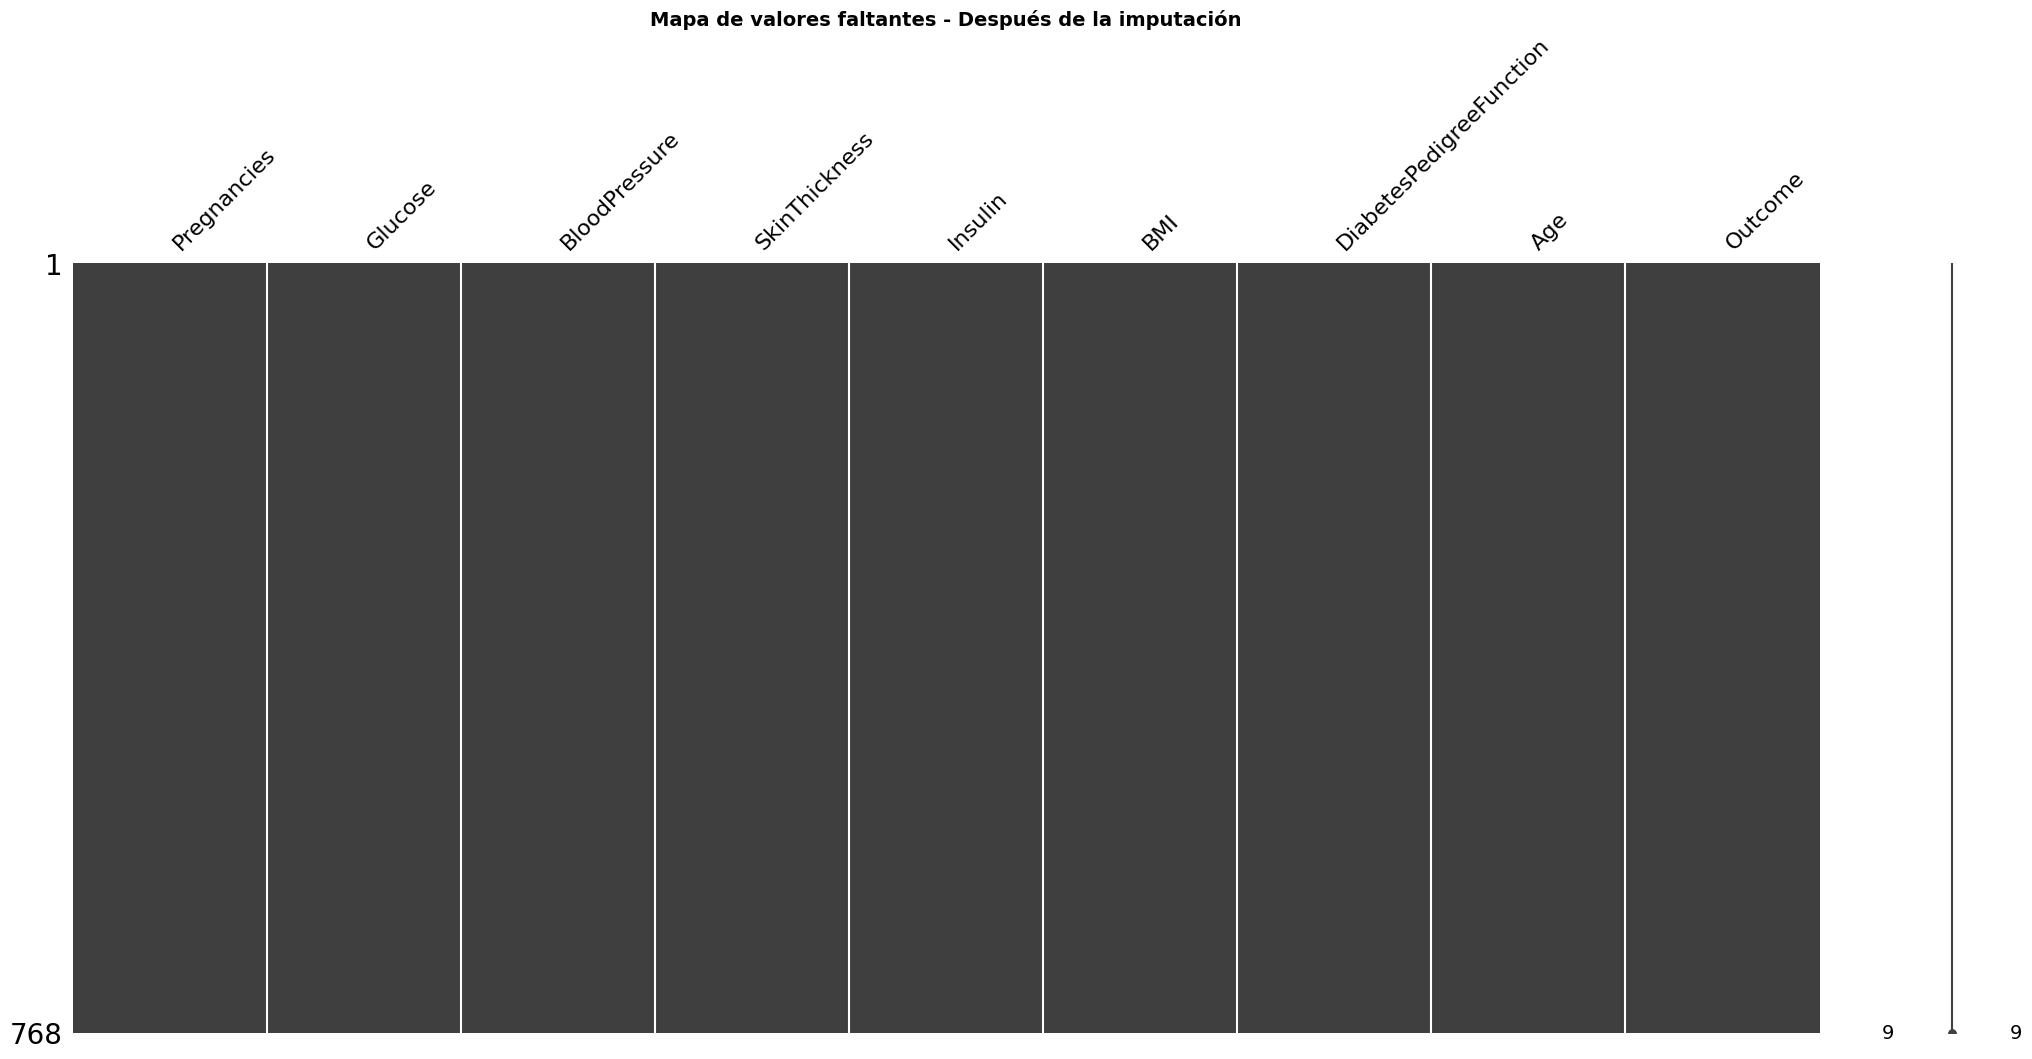

In [15]:
# Visualizar el dataframe después del tratamiento de valores faltantes
msno.matrix(df)
plt.title('Mapa de valores faltantes - Después de la imputación', fontsize=14, fontweight='bold')
plt.show()

In [16]:
# Guardar el dataframe limpio e imputado para uso en otros modelos
os.makedirs('/workspaces/carlos060495-intro-ml/data/processed', exist_ok=True)
df.to_pickle('/workspaces/carlos060495-intro-ml/data/processed/diabetes_clean.pkl')
print("✅ Dataframe guardado exitosamente en: data/processed/diabetes_clean.pkl")
print(f"📊 Forma del dataframe: {df.shape}")
print(f"📋 Columnas: {list(df.columns)}")

✅ Dataframe guardado exitosamente en: data/processed/diabetes_clean.pkl
📊 Forma del dataframe: (768, 9)
📋 Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


# 3.1 Train test split

In [17]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.1 Arbol de desicion simple

In [19]:
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, random_state=42)
simple_tree.fit(X_train, y_train)

complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train, y_train)

# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

In [20]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [21]:
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.742671,0.496815,0.654420,0.772277,0.366197,0.942643
Test,0.727273,0.461538,0.638384,0.782609,0.327273,0.949495
Diferencia,0.015398,0.035277,0.016036,-0.010331,0.038924,-0.006852


In [22]:
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
Test,0.688312,0.59322,0.676768,0.555556,0.636364,0.717172
Diferencia,0.311688,0.40678,0.323232,0.444444,0.363636,0.282828


In [23]:
# Matriz de confusión
cm = confusion_matrix(y_test, test_pred_simple)
cm

array([[94,  5],
       [37, 18]])

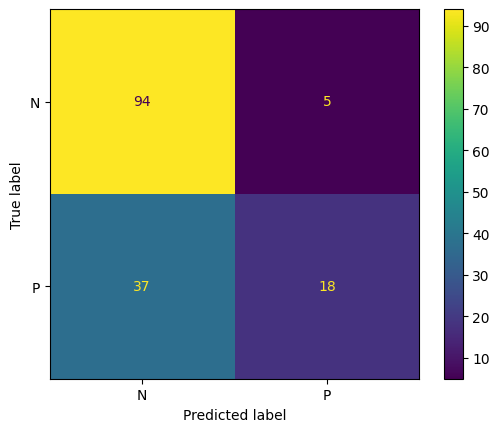

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'P'])
disp.plot()

In [25]:
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Insulin <= 120.51
|   |--- Glucose <= 127.00
|   |   |--- SkinThickness <= 25.94
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  25.94
|   |   |   |--- class: 0
|   |--- Glucose >  127.00
|   |   |--- class: 1
|--- Insulin >  120.51
|   |--- Age <= 24.50
|   |   |--- BMI <= 31.10
|   |   |   |--- class: 0
|   |   |--- BMI >  31.10
|   |   |   |--- class: 0
|   |--- Age >  24.50
|   |   |--- Glucose <= 154.50
|   |   |   |--- class: 0
|   |   |--- Glucose >  154.50
|   |   |   |--- class: 1



# 4.2 Comparación de criterios de pureza

In [26]:
# Definir los criterios a probar
criterios = ['gini', 'entropy', 'log_loss']

# Diccionario para almacenar los modelos y resultados
resultados = {}

# Entrenar un modelo con cada criterio
for criterio in criterios:
    # Crear el modelo
    modelo = DecisionTreeClassifier(
        criterion=criterio,
        max_depth=5,
        min_samples_leaf=15,
        random_state=42
    )
    
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Guardar resultados
    resultados[criterio] = {
        'modelo': modelo,
        'train_pred': y_pred_train,
        'test_pred': y_pred_test,
        'metrics': get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    }
    
print("Modelos entrenados exitosamente para todos los criterios.")

Modelos entrenados exitosamente para todos los criterios.


In [27]:
# Mostrar las métricas de cada criterio
for criterio in criterios:
    print(f"\n{'='*60}")
    print(f"CRITERIO: {criterio.upper()}")
    print(f"{'='*60}")
    print(resultados[criterio]['metrics'])


CRITERIO: GINI
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.828990  0.777070  0.836061   0.709302  0.859155     0.812968
Test        0.701299  0.634921  0.707071   0.563380  0.727273     0.686869
Diferencia  0.127692  0.142149  0.128991   0.145922  0.131882     0.126099

CRITERIO: ENTROPY
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.824104  0.767241  0.826818   0.709163  0.835681     0.817955
Test        0.753247  0.683333  0.751515   0.630769  0.745455     0.757576
Diferencia  0.070857  0.083908  0.075303   0.078394  0.090226     0.060379

CRITERIO: LOG_LOSS
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.824104  0.767241  0.826818   0.709163  0.835681     0.817955
Test        0.753247  0.683333  0.751515   0.630769  0.745455     0.757576
Diferencia  0.070857  0.083908  0.075303   0.078394  0.090226     0.060379

CRITERIO: GINI
            Accuracy        F

In [28]:
# Crear DataFrame comparativo con métricas de test
comparacion_test = pd.DataFrame({
    'Gini': resultados['gini']['metrics'].loc['Test'],
    'Entropy': resultados['entropy']['metrics'].loc['Test'],
    'Log_Loss': resultados['log_loss']['metrics'].loc['Test']
}).T

print("Comparación de métricas en conjunto de TEST:")
print(comparacion_test)

Comparación de métricas en conjunto de TEST:
          Accuracy        F1       AUC  Precision    Recall  Specificity
Gini      0.701299  0.634921  0.707071   0.563380  0.727273     0.686869
Entropy   0.753247  0.683333  0.751515   0.630769  0.745455     0.757576
Log_Loss  0.753247  0.683333  0.751515   0.630769  0.745455     0.757576


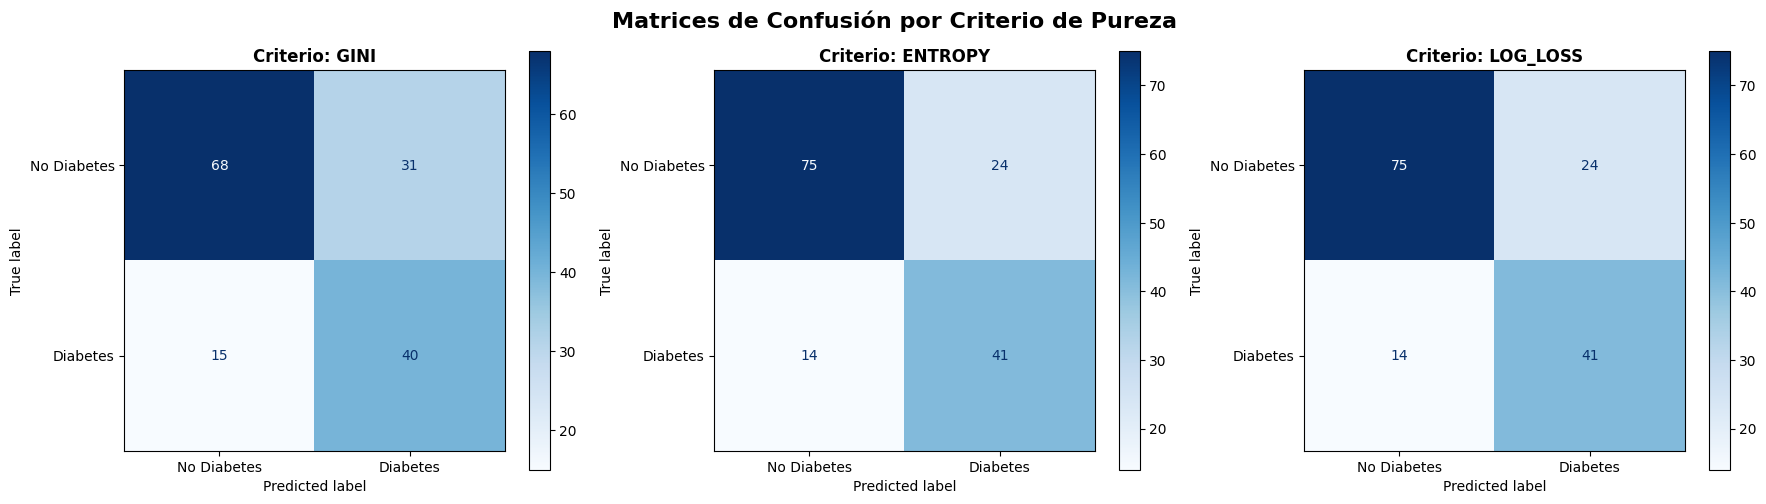

In [29]:
# Comparar matrices de confusión de los tres criterios
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusión por Criterio de Pureza', fontsize=16, fontweight='bold')

for idx, criterio in enumerate(criterios):
    cm = confusion_matrix(y_test, resultados[criterio]['test_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'Criterio: {criterio.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Selección del mejor criterio
Después de analizar los resultados de los tres criterios de pureza, observamos que **Entropy y Log_Loss produjeron métricas idénticas** y superiores a Gini

Hemos seleccionado el criterio **Entropy** para nuestro modelo final de predicción de diabetes.

# 5.1 Hiperparametros

In [30]:
from sklearn.model_selection import GridSearchCV

# Definir el espacio de hiperparámetros para DecisionTreeClassifier
# Ya seleccionamos 'entropy' como mejor criterio, así que lo fijamos
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25],
    'max_features': [None, 'sqrt', 'log2']
}

# Crear el modelo base con criterion='entropy'
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='f1',  # Usamos F1 por el balance entre precision y recall
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Ajustar el modelo
print("Iniciando búsqueda de hiperparámetros con criterion='entropy'...")
grid_search.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print("\n" + "="*60)
print("Mejores hiperparámetros encontrados:")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1 Score en validación cruzada: {grid_search.best_score_:.4f}")

# Guardar el mejor modelo
best_model = grid_search.best_estimator_

Iniciando búsqueda de hiperparámetros con criterion='entropy'...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=5; total tim

In [31]:
# Evaluar el mejor modelo
y_pred_train_best = best_model.predict(X_train)
y_pred_test_best = best_model.predict(X_test)

# Obtener métricas del mejor modelo
best_metrics = get_metrics(y_train, y_test, y_pred_train_best, y_pred_test_best)

print("\n" + "="*60)
print("Métricas del modelo optimizado:")
print("="*60)
print(best_metrics)


Métricas del modelo optimizado:
            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.780130  0.701987  0.772242   0.662500  0.746479     0.798005
Test        0.740260  0.682540  0.749495   0.605634  0.781818     0.717172
Diferencia  0.039871  0.019447  0.022747   0.056866 -0.035339     0.080833


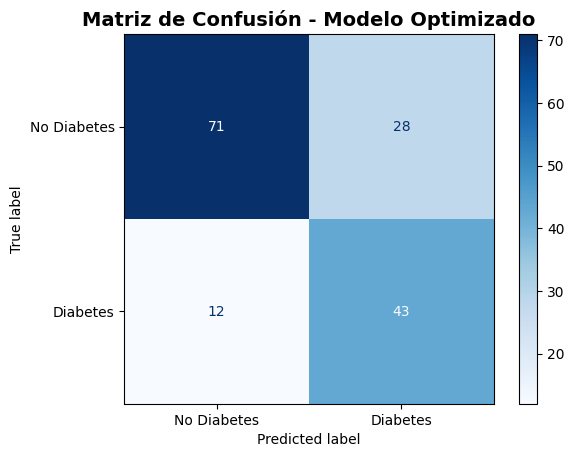

In [32]:
# Matriz de confusión del modelo optimizado
cm_best = confusion_matrix(y_test, y_pred_test_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['No Diabetes', 'Diabetes'])
disp_best.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Modelo Optimizado', fontsize=14, fontweight='bold')
plt.show()

In [33]:


# Crear directorio para modelos si no existe
model_dir = '/workspaces/carlos060495-intro-ml/models'
os.makedirs(model_dir, exist_ok=True)

# Guardar el modelo optimizado
model_path = os.path.join(model_dir, 'decision_tree_diabetes.pkl')
joblib.dump(best_model, model_path)

print(f"✅ Modelo guardado exitosamente en: {model_path}")
print(f"📊 Tamaño del archivo: {os.path.getsize(model_path) / 1024:.2f} KB")

✅ Modelo guardado exitosamente en: /workspaces/carlos060495-intro-ml/models/decision_tree_diabetes.pkl
📊 Tamaño del archivo: 3.59 KB
